In [1]:
import pandas as pd
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import IPython.display as display
from matplotlib import animation
import torch
from torch.utils.data import DataLoader
import copy
from torch import nn
%matplotlib inline
import matplotlib.pyplot as plt
import random
from dnaDataloader import expermentDataloader
from dnaDataloader import addData
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
batch_size = 10
device

device(type='cuda', index=2)

#### large dataset
----

In [2]:
datasetLarge = expermentDataloader(
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/large_dataset/allData/index.csv",
    "/home/khood/GitHub/SNN-DNA-project/Prepocessing/large_dataset/allData/", 
)
print(f"datasetLarge:{len(datasetLarge)}")

datasetLarge:3862


In [3]:
rawData = [datasetLarge[i] for i in list(range(len(datasetLarge)))]
trainData = []
testValid = []
addData(trainData, testValid, rawData, rhsSize=int(len(rawData)*0.2))
testData = []
validData = []
addData(testData, validData, testValid, rhsSize=int(len(testValid)*0.6))

trainDataset = DataLoader(trainData, batch_size=batch_size, shuffle=True)
testDataset = DataLoader(testData, batch_size=batch_size, shuffle=True)
validDataset = DataLoader(validData, batch_size=batch_size, shuffle=True)
print(f"Training dataset size: {len(trainData)}")
print(f"Testing dataset size: {len(validData)}")
print(f"Valid dataset size: {len(testData)}")
print(f"Total: {len(trainData) + len(validData) + len(testData)}")
print(f"number train batches:{len(trainDataset)}")
print(f"number test batches:{len(testDataset)}")
print(f"number valid batches:{len(validDataset)}")

Training dataset size: 3090
Testing dataset size: 463
Valid dataset size: 309
Total: 3862
number train batches:309
number test batches:31
number valid batches:47


In [4]:
featIn = 12000
model = nn.Sequential(
          nn.Linear(featIn,24000),
          nn.ReLU(),
          nn.Linear(24000,24000),
          nn.ReLU(),
          nn.Linear(24000,24000),
          nn.ReLU(),
          nn.Linear(24000,1),
        )
model.to(device)
MSE = nn.MSELoss(reduction = 'sum')
adam = torch.optim.Adam(model.parameters(),lr=0.000001)

em = 20
epochs = 100
losses = []
accs = []
print("training...")
for e in range(epochs): 
    model.train()
    for i, (inputs, targets) in enumerate(trainDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        loss = MSE(outputs, targets)
        adam.zero_grad()
        loss.backward()
        adam.step()
        
    avgLoss = []
    currentAcc = []
    model.eval()
    for i, (inputs, targets) in enumerate(validDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        loss = MSE(outputs, targets)
        outputPlot = outputs.clone().detach().cpu().numpy()
        targetsPlot = targets.clone().detach().cpu().numpy()
        avgLoss.append(float(loss.clone().detach().cpu().numpy()))
        totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
        totalCorrect = totalCorrect.clone().detach().cpu().numpy()
        currentAcc.append(float(totalCorrect/len(targets)))
        print(f"\
        epoch: {e}/{epochs}\t \
        loss:{np.sum(avgLoss)/len(avgLoss)}\t \
        accuracy:{np.sum(currentAcc)/len(currentAcc)} \
        ",end="\x1b\r")
    accs.append(float(np.sum(currentAcc)/len(currentAcc)))
    losses.append(float(np.sum(avgLoss)/len(avgLoss)))

training...


KeyboardInterrupt: 

In [ ]:
defultePlotSize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = [20, 5]
plt.subplot(1, 2, 1)
plt.title('accuracy vs epochs')
plt.plot(list(range(len(accs))), accs, '-', color='black', )
plt.subplot(1, 2, 2)
plt.title('losse vs epochs')
plt.plot(list(range(len(losses))), losses, '-', color='black')
plt.rcParams['figure.figsize'] = defultePlotSize
epochs*len(validDataset)

In [ ]:
from datetime import datetime
title = "working with large dataset"
dt_string = datetime.now().strftime("%d.%m.%Y_%H-%M-%S-%f")
modelPath = f"./Models/{title.replace(' ', '_')}_{dt_string}.pt"
torch.save(model.state_dict(),modelPath)
print(f"saved to {modelPath}")

test...


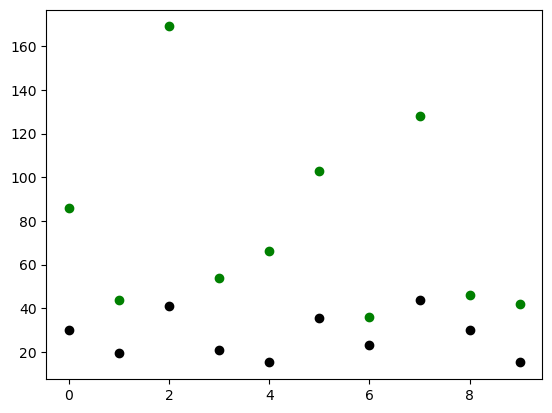

In [ ]:
em =40
epochs = 50
accs = []
model.eval()
print("test...")
for e in range(epochs): 
    avgLoss = []
    currentAcc = []
    for i, (inputs, targets) in enumerate(largeDataset):
        inputs, targets= inputs.float().to(device), targets.float().to(device)
        outputs = model(inputs)
        if(len(outputs) == batch_size):
            outputPlot = outputs.clone().detach().cpu().numpy()
            targetsPlot = targets.clone().detach().cpu().numpy()
            totalCorrect = torch.sum(torch.isclose(outputs.int(), targets.int(), atol=em))
            totalCorrect = totalCorrect.clone().detach().cpu().numpy()
            currentAcc.append(float(totalCorrect/len(targets)))
            accs.append(float(totalCorrect/len(targets)))

print(f"\
    accuracy:{np.sum(accs)/len(accs)} \
    ",end="\x1b\r")

plt.plot(list(range(len(outputPlot))), outputPlot, 'o', color='black')
plt.plot(list(range(len(targetsPlot))), targetsPlot, 'o', color='green')